## Importing Libraries

In [3]:
!pip install torchviz
!pip install segmentation_models_pytorch

  Using cached torchviz-0.0.2-py3-none-any.whl


In [4]:
import numpy as np
import pandas as pd
import os

import cv2
import random
import tqdm
from tqdm import notebook
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,datasets
import torchvision
import torch
from PIL import Image
import torch.nn as nn
from torchviz import make_dot

#Importing the library into the notebook
import segmentation_models_pytorch as seg_models

## Checking out an example

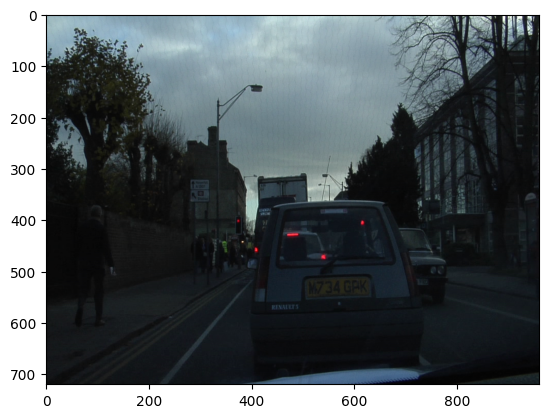

In [5]:
image_dir = "/kaggle/input/camvid"


# Print any image of your choice from the training set
s_no = 20

img = Image.open("/kaggle/input/camvid/CamVid/train/0001TP_009210.png").convert("RGB")

plt.imshow(img)
plt.show()
train_dir_input="/kaggle/input/camvid/CamVid/train"
train_dir_output="/kaggle/input/camvid/CamVid/train_labels"
valid_dir_input="/kaggle/input/camvid/CamVid/val"
valid_dir_output="/kaggle/input/camvid/CamVid/val_labels"
test_dir_input="/kaggle/input/camvid/CamVid/test"
test_dir_output="/kaggle/input/camvid/CamVid/test_labels"

The images and their labels are clubbed together. We'll have to separate while loading them as well.

## Data Loader Pipeline

In [6]:
class CustomDataset(Dataset):
    def __init__(self, in_dir,target_dir, transform=None):
        self.input_folder=in_dir
        self.target_folder=target_dir
        self.transform=transform
        
        self.input_files=os.listdir(self.input_folder)
        self.target_files=os.listdir(self.target_folder)
    
    def __len__(self):
        return len(self.input_files)
    
    def __getitem__(self, index):
        inputs = os.path.join(self.input_folder, self.input_files[index])
        targets=  os.path.join(self.target_folder, self.target_files[index])
        
        input_image=Image.open(inputs)
        target_image=Image.open(targets)
        
        if self.transform:
            input_image=self.transform(input_image)
            target_image=self.transform(target_image)
        
        return input_image,target_image

transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
])
train_dataset=CustomDataset(train_dir_input,train_dir_output,transform=transform)
valid_dataset=CustomDataset(valid_dir_input,valid_dir_output,transform=transform)
test_dataset=CustomDataset(test_dir_input,test_dir_output,transform=transform)

#{Input+Target}
train_dataloader=DataLoader(train_dataset,batch_size=4,shuffle=True)
valid_dataloader=DataLoader(valid_dataset,batch_size=4,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=4,shuffle=True)

## Models

Storing the names of the models to be used and their instances in a dictionary.

In [7]:
names = ["DeepLabV3+"]
models_dict = {
    "DeepLabV3+": seg_models.DeepLabV3Plus(classes=3),
}

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 232MB/s]


## Accuracy


In [8]:
def accuracy(output,labels):
    correct = (output == labels).sum().item() 

    acc=100*correct/torch.numel(labels)

    return acc

## Train Function

In [9]:
from statistics import mean
def training(model, epochs,optimizer, batch_size):
    
 
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    main_pbar = tqdm.notebook.tqdm(range(epochs))
    main_pbar.set_description('common progress ')
    criterion = torch.nn.BCEWithLogitsLoss()
    d=[]
    
    for epoch in main_pbar:
        train_pbar = tqdm.notebook.tqdm(range(len(train_dataloader)))
        
        for step in train_pbar:
             
            for train_imgs,train_masks in train_dataloader:
                train_imgs, train_masks = train_imgs.to(device), train_masks.to(device)
                
                optimizer.zero_grad()
                
                train_predictions = model(train_imgs)

                train_loss = criterion(train_predictions, train_masks)
                train_loss.backward()
                

                optimizer.step()
#         print(f'Training Accuracy in epoch {epoch}={sum(acc1)/len(train_dataloader)}')
        
        
       
        with torch.no_grad():
            for test_images,test_masks in valid_dataloader:
                test_images, test_masks = test_images.to(device), test_masks.to(device)
            
                test_predictions = model(test_images)
    
                test_loss = criterion(test_predictions, test_masks)
        
                test_dice = accuracy( test_predictions.to(torch.int32), test_masks.to(torch.int32))
                d.append(test_dice)
            torch.cuda.empty_cache()
            print(f'Valid acc={sum(d)/len(d)}')

**Test**


In [10]:
def test(model):
    d=[]
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    for i,m in test_dataloader:
        test_images, test_masks = i.to(device), m.to(device)
                        
        test_predictions = model(test_images)
        #test_dice = iou( test_predictions.to(torch.int32), test_masks.to(torch.int32))
        test_acc = accuracy( test_predictions.to(torch.int32), test_masks.to(torch.int32))
        d.append(test_acc)
    return sum(d)/len(d)

## Training & Saving Weights

In [11]:
# Stores the values of losses and dice coeff.

for model_name, model_instance in models_dict.items():
    name = model_name
    model_name = model_instance
    model_name.to("cuda:0")
    x = torch.zeros(8, 3, 128, 128, dtype=torch.float, requires_grad=False)
    x = x.to("cuda:0")
    outputs_x = model_name(x)
    make_dot(outputs_x, params=dict(list(model_name.named_parameters())))
    
    optimizer = torch.optim.Adam(params = model_name.parameters(), 
                             lr=1e-4, 
                             betas=(0.9, 0.999), 
                             eps=1e-08, 
                             weight_decay=0, 
                             amsgrad=False)


    
    training(model = model_name,optimizer=optimizer, epochs = 1, batch_size = 32)
    
    
    # Saving the model weights for each model in working directory
    working_dir = '/kaggle/working/'
    weights_path = os.path.join(working_dir, name + '_weights.pth')
    logs_path = os.path.join(working_dir, name + '_logs')
    torch.save(model_name.state_dict(), weights_path)
    print(f'Test ACC={test(model_name)}')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

Valid acc=79.52236228641752
Test ACC=76.33314107970193


## Results of each model

In [12]:
def show(model_name, num_cols):
    generator = valid_dataloader
    result = []
    for iteration in range(num_cols):
        for images,masks in generator:
            images_1 = images.to("cuda:0")
            
            prediction = torch.sigmoid(model_name(images_1))
            prediction = prediction.cpu().detach().numpy()
            prediction = np.moveaxis(prediction, 1, -1)
            masks = np.moveaxis(masks.numpy(), 1, -1)
            images = np.moveaxis(images.numpy(), 1, -1)
            prediction = np.concatenate(prediction)
            images = np.concatenate(images)
            masks = np.concatenate(masks)
            outputs = np.hstack([images, masks, prediction])
            result.append(outputs)
            break
        break
    result = np.hstack(result)
    plt.figure(figsize = (30, 30))
    plt.axis('off')
    plt.imshow(result)

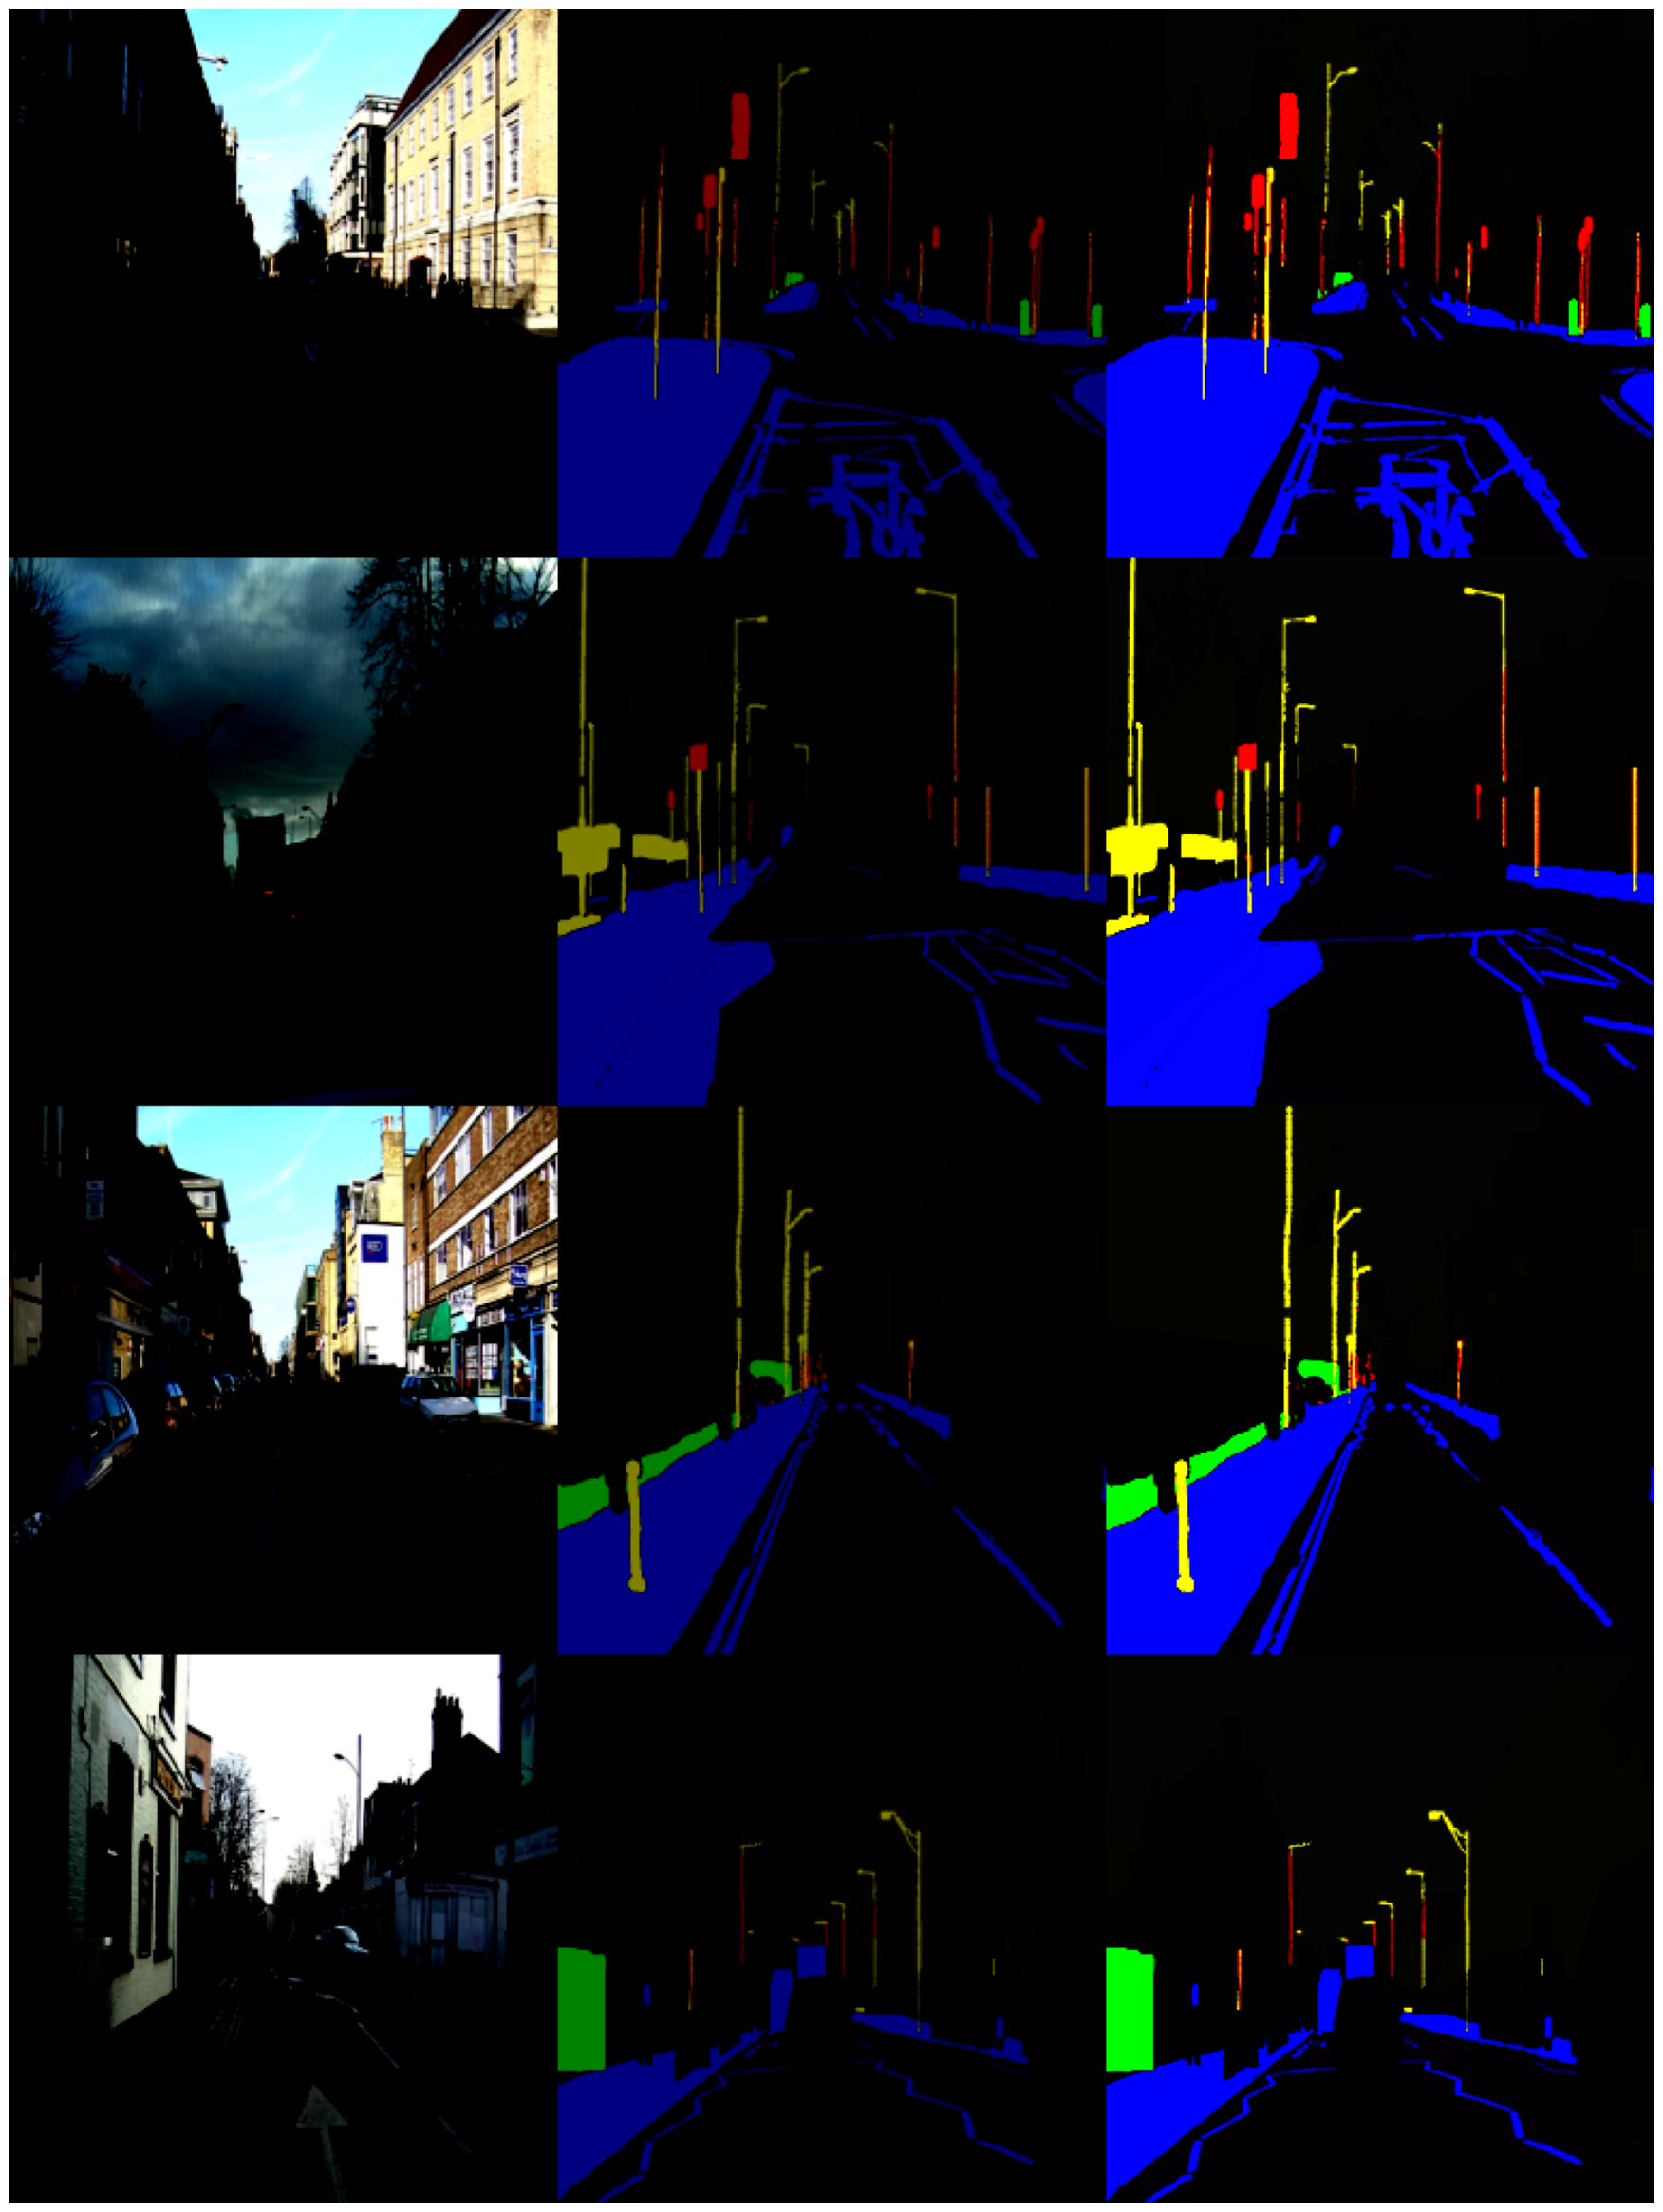

In [13]:
name = "DeepLabV3+"
model_name = models_dict["DeepLabV3+"]
model_name.load_state_dict(torch.load(os.path.join(working_dir, name + '_weights.pth')))
model_name.eval()
show(model_name, num_cols = 2)